# Startup 
Code to be included at the beginning of each Julia script.

Define directories and call packages.

In [1]:
t0 = time() ## start chrono
dir_module = joinpath(pwd(),"src")
    
########### main module
using NBInclude
@nbinclude(joinpath(dir_module,"Agglo.ipynb"))
using Main.Agglo

########### other packages
using Roots, PyPlot, NLopt, DataFrames

# Define parameters

In [2]:
## to avoid repeating operations at every initial_StrucPar
directplug = let
    
    ## external targets
    r_annual = 0.05 # 5% annual interest rate
    outmigration_yearly = 0.029 #2.9% steady state outflow 
    separationrate_monthly = 0.03 # 3% Shimer 2012
    N2Urate_monthly = 0.015 # 0.015 roughly from Elsby, M, Hobijn, B & Sahin, A, JME 2015
    participationrate = 0.65 # 0.65 roughly from Elsby, M, Hobijn, B & Sahin, A, JME 2015 
    unemploymentrate = 0.06
    jobfillingrate_daily = 0.05 ##5% daily job-filling rate 
    d_star = 1  ## normalisation

    ### plug the values
    r = find_zero(x->1-exp(-12*x)-r_annual, 0.004)
    Phi_star = find_zero(x->1-exp(-12*x)-outmigration_yearly, 0.0001) * d_star 
    rho = Phi_star/d_star ## d at steady state
    q_star = find_zero(x->1-exp(-12/365*x)-jobfillingrate_daily, 0.) 
    l_star = participationrate * d_star
    m_star = (1-unemploymentrate) * l_star 
    rholamdelta = separationrate_monthly ## rho+lambda+delta
    theta_star=rholamdelta * m_star / (q_star * (l_star-m_star))  ## m at SS
    n_star = theta_star * (l_star-m_star) + m_star ## def of theta

    (r=r, d_star=d_star, Phi_star=Phi_star, rho=rho, l_star=l_star, m_star=m_star, theta_star=theta_star,
        q_star=q_star, theta_q_star= theta_star * q_star, n_star=n_star, 
        rholamdelta =rholamdelta, N2Urate_monthly=N2Urate_monthly)
    
end

function initial_StrucPar_generic(a::Float64, delta_jump::Float64, A_drop::Float64, nuF::Float64, nuPhi::Float64, nuPsi::Float64, 
        version::Symbol; dp=directplug)

    ## external targets
    eta =0.4 ## provided by referee 1
    beta = 1-eta ## Hosios condition
    Y_star = 1.
    b= 0.4*Y_star ## Shimer
    Ztilde = 0. # innocuous normalisation
    Vtilde = 0. # assumption
    housingshare = 0.25 ## housing cost/wage, from Davis and Ortalo-Magne
    K_star = 0 # Coles and Moghaddasi
    chi=0
    c=0
    eHd = 1
    eHn = 0 
    eKd = 0
    eKn = 0
    eYd = 0 
    eYn = 0.2
    
    ### plug the values
    r = dp.r
    d_star= dp.d_star
    l_star=dp.l_star
    m_star=dp.m_star
    Phi_star = dp.Phi_star     
    rho = dp.rho
    q_star = dp.q_star
    theta_star = dp.theta_star
    theta_q_star = dp.theta_q_star
    n_star=dp.n_star
    
    ## need to find a fixed point
    gamma_fun(F) = dp.N2Urate_monthly / F
    lambda_fun(F, gam) = (F*Phi_star + dp.N2Urate_monthly*(d_star-l_star) -rho*l_star - gam*(1-F)*(l_star-m_star)) / l_star ## transition N2U and l at SS
    S_fun(gam, P) = (Y_star-b+c + gam*G_fun(P,nuF)) / (r+dp.rholamdelta+beta*theta_star * q_star+(1-beta)*q_star)  ## S at SS
    P_fun(lam, gam, S) = (-c+ beta*theta_star*q_star * S) / (r+rho+lam+chi+gam) ## P at SS
    function fixpoint(P)
        F = F_fun(P, nuF)
        gam=gamma_fun(F)
        lam = lambda_fun(F, gam)
        S = S_fun(gam, P)
        return P - P_fun(lam, gam, S)
    end
    P_star = find_zero(fixpoint, 10)
    F_star = F_fun(P_star,nuF)
    gamma=gamma_fun(F_star)
    lambda = lambda_fun(F_star, gamma)
    S_star = S_fun(gamma, P_star)
    
    ## and the rest
    delta = dp.rholamdelta - rho - lambda
    Psi_star = delta*n_star
    Sw_star = beta * S_star
    Sf_star = (1-beta) * S_star
    w_star = Y_star - (r+rho+lambda+delta+q_star) *  Sf_star ## def of Sf
    H_star = housingshare * w_star 
    U_star = (rho*Ztilde + b-H_star-c + beta*theta_q_star*S_star  - lambda*P_star - gamma*G_fun(P_star,nuF) )/ (r+rho) ## U at SS
    V_star = (delta*Vtilde-K_star+(1-beta)*q_star*S_star)/(r+delta) ## V at SS
    Z_star = U_star-G_fun(P_star,nuF)
    
    ###################
    StrucPar(r=r,eta=eta,beta=beta,delta=delta,rho=rho,lambda=lambda, chi=chi, 
        Psi_star=Psi_star, Phi_star=Phi_star,
        q_star=q_star, theta_q_star=theta_q_star, theta_star = theta_star,
        d_star=d_star, l_star=l_star, m_star =m_star, n_star=n_star,
        gamma=gamma, nuPhi=nuPhi , nuPsi=nuPsi, nuF=nuF,
        Y_star=Y_star, b=b, c=c, Ztilde=Ztilde, Vtilde=Vtilde,
        S_star = S_star, Sw_star=Sw_star, Sf_star=Sf_star,
        w_star = w_star,
        H_star = H_star, K_star = K_star,
        P_star= P_star, U_star = U_star, V_star = V_star, Z_star=Z_star,
        eHd=eHd, eHn=eHn, eKd=eKd, eKn=eKn, eYd=eYd, eYn=eYn, 
        a=a, delta_jump=delta_jump, A_drop=A_drop, version=version)
end


p0 = initial_StrucPar_generic(0., 0.,0.,0.1, 0.,0., :newb)
function initial_StrucPar_base(a::Float64, delta_jump::Float64, A_drop::Float64, nuF::Float64, nuPhi::Float64, nuPsi::Float64)
    initial_StrucPar_generic(a, delta_jump, A_drop, nuF, nuPhi, nuPsi, :base)
end

function initial_StrucPar_noagglo(a::Float64, delta_jump::Float64, A_drop::Float64, nuF::Float64, nuPhi::Float64, nuPsi::Float64)
    p1=initial_StrucPar_generic(a, delta_jump, A_drop, nuF, nuPhi, nuPsi, :base)
    StrucPar_agglo(0,0,0,0,0,0, p1)
end

function initial_StrucPar_rigidwage(a::Float64, delta_jump::Float64, A_drop::Float64, nuF::Float64, nuPhi::Float64, nuPsi::Float64)
    initial_StrucPar_generic(a, delta_jump, A_drop, nuF, nuPhi, nuPsi, :rigidwage)
end

function initial_StrucPar_rigidrent(a::Float64, delta_jump::Float64, A_drop::Float64, nuF::Float64, nuPhi::Float64, nuPsi::Float64)
    initial_StrucPar_generic(a, delta_jump, A_drop, nuF, nuPhi, nuPsi, :rigidrent)
end

function initial_StrucPar_stat(a::Float64, delta_jump::Float64, A_drop::Float64, nuF::Float64, nuPhi::Float64, nuPsi::Float64)
    initial_StrucPar_generic(a, delta_jump, A_drop, nuF, nuPhi, nuPsi, :stat)
end

initial_StrucPar_stat (generic function with 1 method)

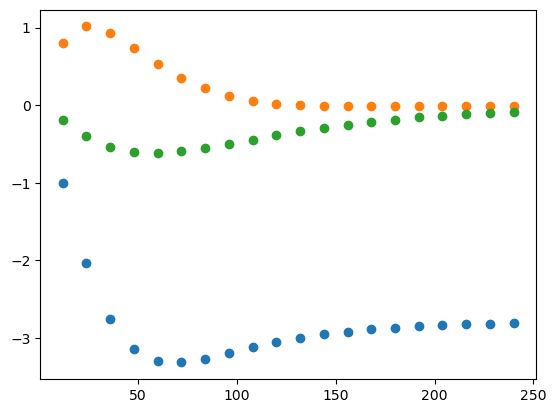

PyObject <matplotlib.collections.PathCollection object at 0x000002085595D9D0>

In [3]:
simpar = let
    M = 1000
    lastobs = 1200 ##(M-2)/mu = t_{M-1} last observation before infinity 
    mu = (M-2)/lastobs
    
    ## build datamom, the columns are from HandIRF_RFIV_persistent_no_covid.xlsx
    t = 12 .* collect(1:20) ## every year for the next 10 years
    emp = [-1,
-2.03516279295191,
-2.75122090528639,
-3.13989482962082,
-3.29638275347455,
-3.31620117208818,
-3.26840510063065,
-3.19553251903024,
-3.12044344103286,
-3.05345423938016,
-2.99781163998253,
-2.95328243345294,
-2.91824443229933,
-2.89077051089269,
-2.8691107434514,
-2.85185076299132,
-2.83791639408314,
-2.82651876194693,
-2.81708670435878,
-2.80920640188485
            ]
    urate = [0.798166437251351,
1.01335091224359,
0.933781606724633,
0.739777545372322,
0.530248279016484,
0.350580331200598,
0.214483557223323,
0.119793271527241,
0.0582810393667188,
0.0208101802768431,
-0.000453148162926895,
-0.0114223264679098,
-0.0162079349198806,
-0.0174945817590769,
-0.0169450280287167,
-0.0155387783260611,
-0.013822957725632,
-0.0120839844711436,
-0.0104582315457598,
-0.00899989325686042
            ]
    prate = [-0.185297307499995,
-0.392055625577903,
-0.536669774968169,
-0.604583386671608,
-0.617099957152784,
-0.594744687215814,
-0.552181867521033,
-0.499648750670381,
-0.444040112027971,
-0.389667704803717,
-0.338961194300422,
-0.293077749919438,
-0.252372920417869,
-0.216733947230121,
-0.18580087808487,
-0.159105011589948,
-0.136150444863877,
-0.116458604680253,
-0.0995899222770024,
-0.0851521314931289
            ]
    data = DataFrame(t=t, emp=emp, urate=urate, prate=prate)
    SimPar(M = M, mu =mu, h = 0.2, maxiter=200, maxerr=0.001, data=data) 
end

scatter(simpar.data.t,simpar.data.emp)
scatter(simpar.data.t,simpar.data.urate)
scatter(simpar.data.t,simpar.data.prate)

In [4]:
## specify colors, https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=7
myblue = "#7570b3"
mygreen= "#1b9e77"
myred = "#d95f02"
mypink = "#e7298a"
mylightgreen = "#66a61e"
myorange = "#e6ab02"
mybrown = "#a6761d"
mygrey = "#bfbfbf"

## ordered colored and lines
colorvec = [myblue, myred, mygreen,mypink, mylightgreen, myorange, mybrown]
lsvec = ["-", "--",":","-.", (0, (3, 1, 1, 1, 1, 1)), (5, (10, 3)), (0, (3, 10, 1, 10, 1, 10))]

7-element Vector{Any}:
 "-"
 "--"
 ":"
 "-."
 (0, (3, 1, 1, 1, 1, 1))
 (5, (10, 3))
 (0, (3, 10, 1, 10, 1, 10))

In [5]:
if !@isdefined(_VERS_)
    p = NaN 
elseif _VERS_ == :base 
    p = initial_StrucPar_base(79.631263600718, 0.0, 0.07844783149927109, 1.2337220994416365, 0.06449929488793682, 1.4965023959025525)
elseif _VERS_ == :rigidrent 
    p = initial_StrucPar_rigidrent(49.805998561881594, 0.0, 0.03592587505826447, 1.938254345632176, 0.21346740642082493, 5.461586819255724)
elseif _VERS_ == :rigidwage 
    p = initial_StrucPar_rigidwage(13.459713595432413, 0.0, 0.06874436711655102, 8.285702150626136, 2.44522060308835, 0.1755513264749144)
end

NaN

In [6]:
t1 = time()
nsec = (t1-t0)
println("Startup run in $nsec secs.")

Startup run in 40.61999988555908 secs.
